*Note - you can find the nbviewer of this post [here](https://github.com/choldgraf/write-ups/blob/master/neuro/coherence_correlation.ipynb)*

# Coherence vs. Correlation - a simple simulation
A big question that I've always wrestled with is the difference between correlation and coherence. Intuitively, I think of these two things as very similar to one another. Correlation is a way to determine the extent to which two variables covary (normalized to be between -1 and 1). Coherence is similar, but instead assesses "similarity" by looking at the similarity for two variables in frequency space, rather than time space.

There was a nice paper that came out a while back that basically compared these two methods in order to see when they'd produce the same result, when they'd produce different results, and when they'd break down [1]. They made a lot of nice plots like this:

<img src='../../images/2015/eeg_coh.png' style='width:300px' />

Here I am recreating this result in the hopes of giving people a set of scripts to play around with, and giving a bit more intuition.

[1] http://www.ncbi.nlm.nih.gov/pubmed/8947780

---

First things first, we'll import some tools to use

In [ ]:
import pandas as pd
import mne
from itertools import product
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('white')
%matplotlib inline

## Creating our sine waves
Recall that the equation for a sinusoidal wave is:

$$ Asin(2{\pi}ft + 2\pi\phi)$$

Where $f$ is the frequency of the wave, $$t$$ indexes time, and $$2\pi\phi$$ defines a phase offset of the wave. Then, $$A$$ scales the wave's amplitude.

In [ ]:
# We can generate these sine wave parameters, then stitch them together
amplitude_values = [1, 3, 10, 15]
phase_values = [0, .25, .33, .5]
freq = 2
signal_vals = list(product(amplitude_values, phase_values))
amps, phases = zip(*signal_vals)

# We'll also define some noise levels to see how this affects results
noise_levels = [0, 2, 4, 8]

# Now define how long these signals will be
t_stop = 50
time = np.arange(0, t_stop, .01)

# We're storing everything in dataframes, so create some indices
ix_amp = pd.Index(amps, name='amp')
ix_phase = pd.Index(phases, name='phase')

# Create all our signals
signals = []
for noise_level in noise_levels:
    sig_ = np.array([amp * np.sin(freq*2*np.pi*time + 2*np.pi*phase) for amp, phase in signal_vals])
    noise = noise_level * np.random.randn(*sig_.shape)
    sig_ += noise
    ix_noise = pd.Index([noise_level]*sig_.shape[0], name='noise_level')
    ix_multi = pd.MultiIndex.from_arrays([ix_amp, ix_phase, ix_noise])
    signals.append(pd.DataFrame(sig_, index=ix_multi))
signals = pd.concat(signals, 0)
signals.columns.name = 'time'

## Computing connectivity 
Now we've got a bunch of sinewaves with the parameters chosen above. Next, we will calculate the coherence and the correlation between all pairs of signals. This way we can see how these values change for different kinds of input signals.

In [ ]:
con_all = []
for ix_noise, sig in signals.groupby(level='noise_level'):
    # Setting up output indices
    this_noise_level = sig.index.get_level_values('noise_level').unique()[0]
    ix_ref = np.where(sig.eval('amp==3 and phase==0'))[0][0]
    ix_time = pd.Index(range(sig.shape[0]), name='time')
    ix_cc = pd.Index(['cc']*sig.shape[0], name='con')
    ix_coh = pd.Index(['coh']*sig.shape[0], name='con')

    # Calculating correlation is easy with pandas
    cc = sig.T.corr().astype(float).iloc[:, ix_ref]
    cc.name = None
    cc = pd.DataFrame(cc)
    # We'll use MNE for coherenece
    indices = (np.arange(sig.shape[0]), ix_ref.repeat(sig.shape[0]))
    con, freqs, times, epochs, tapers = mne.connectivity.spectral_connectivity(
        sig.values[None, :, :], sfreq=freq, indices=indices)
    con_mn = con.mean(-1)
    con_mn = pd.DataFrame(con_mn, index=cc.index)
    
    # Final prep
    con_mn = con_mn.set_index(ix_coh, append=True)
    cc = cc.set_index(ix_cc, append=True)
    con_all += ([con_mn, cc])
con_all = pd.concat(con_all, axis=0).squeeze().unstack('noise_level')

## Visualizing results
First off, we'll look at what happens to sine waves of varying parameters, for different levels of noise.

Remember, each tuple is (amplitude, phase_lag). The first number controls how large the signal is, and the second controls the difference in phase between two sine waves. 

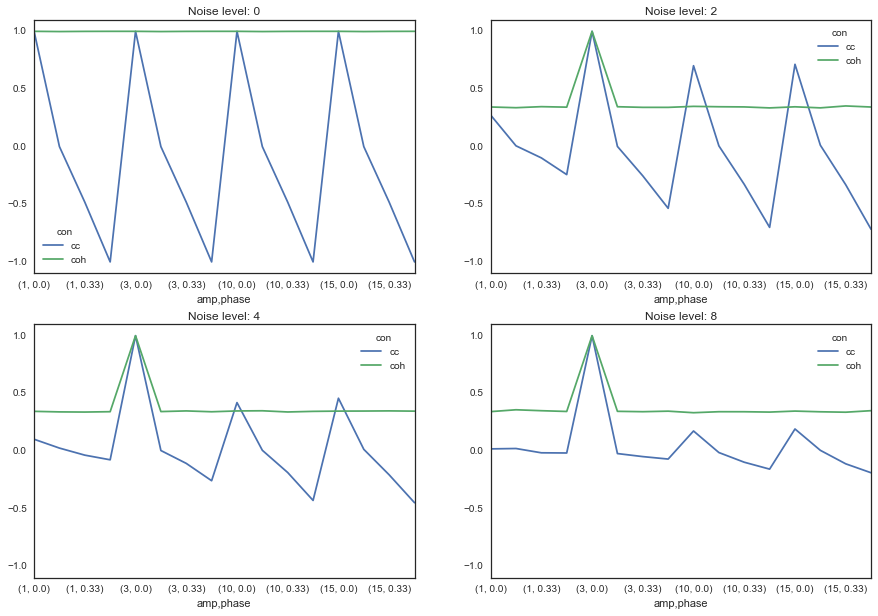

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(15, 10))
for ax, (noise, vals) in zip(axs.ravel(), con_all.iteritems()):
    ax = vals.unstack('con').plot(ax=ax)
    ax.set_title('Noise level: {0}'.format(noise))
    ax.set_ylim([-1.1, 1.1])

That's already an interesting picture - as you can see, coherence is far more robust to differences between the two signals. Here are a few thoughts:

1. Correlation varies widely (between 0 and 1) for differences in phase lag. However, coherence remains relatively stable.
1. Coherence values are smaller in general for a signal with any noise
1. However, coherence is more robust for increasing levels of noise, while correlations start to drop to 0

To illustrate number 1, let's plot correlation and coherence against each other:

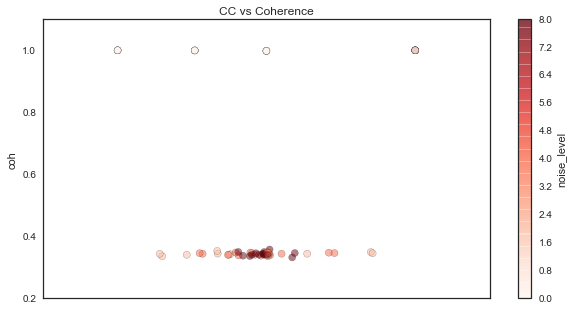

In [ ]:
plt_df = con_all.stack('noise_level').unstack('con').reset_index('noise_level')
ax = plt_df.plot('cc', 'coh', c='noise_level', kind='scatter',
                 cmap=plt.cm.Reds, figsize=(10, 5), alpha=.5, s=50)
ax.set_title('CC vs Coherence')

As you can see here, coherence remains the same (except for when it occasionally increases to 1) while correlation is much more dependent on the phase relationship between the signals. Moreover, as the signal SNR degrades, the correlation shrinks to 0, while the coherence remains the same.

Let's take a look at how the correlation and coherence relate to the actual shape of the signals:

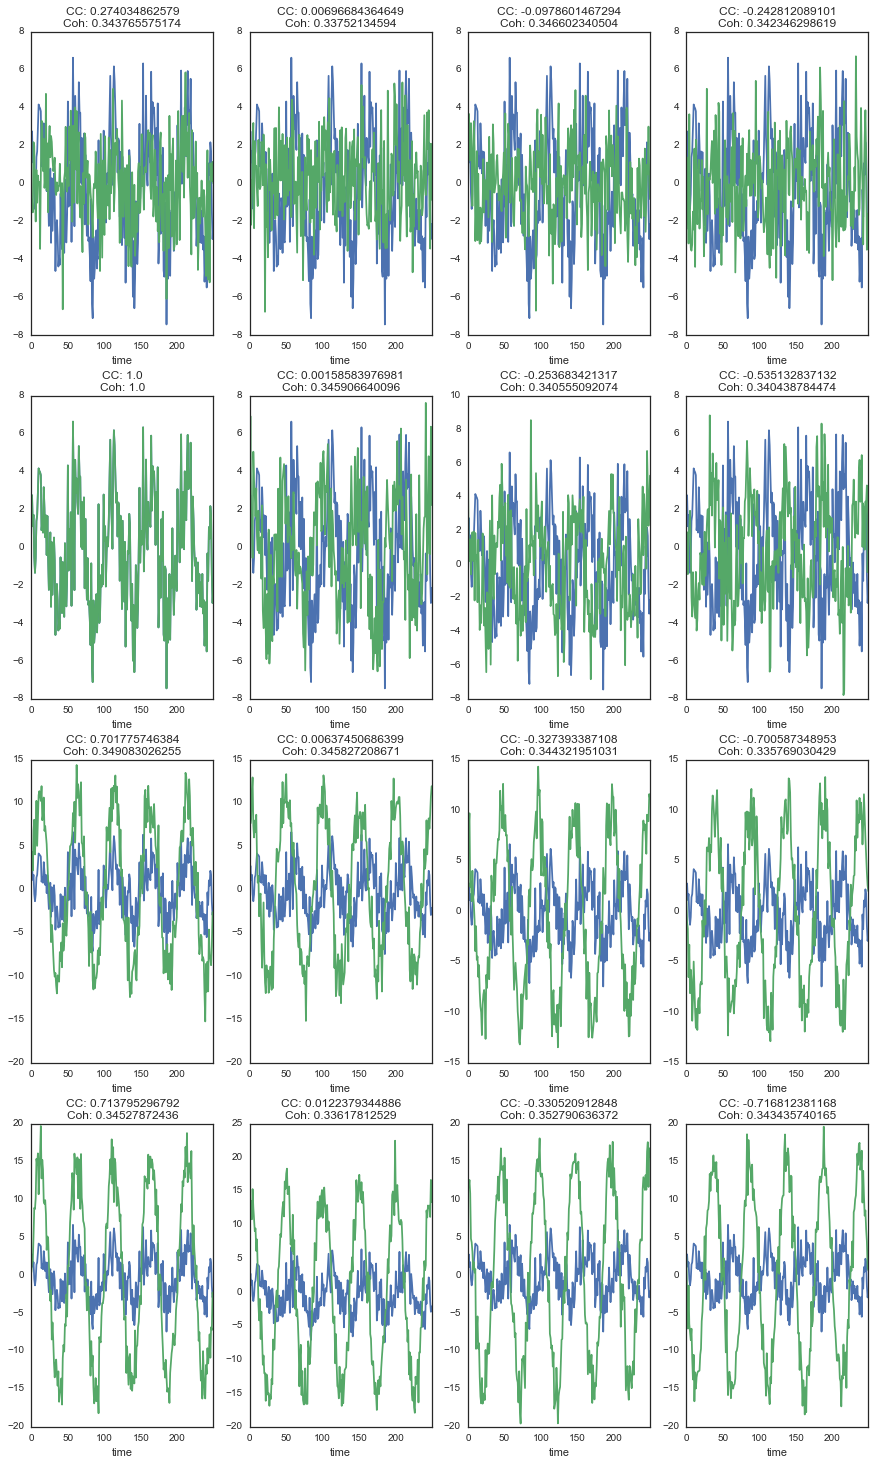

In [ ]:
# Set up a dataframe for plotting
noise_level = noise_levels[1]
plt_df = con_all.copy()
plt_df = con_all[noise_level].unstack('con')

# Define 16 signals to plot
sig_combinations = list(product([ix_ref], range(16)))

plt_sig = signals.xs(noise_level, level='noise_level')
n_combs = len(sig_combinations)
f, axs = plt.subplots(n_combs/4, 4, figsize=(15, n_combs/3*5))
for (comp_a, comp_b), ax in zip(sig_combinations, axs.ravel()):
    plt_sig.iloc[[comp_a, comp_b]].T.head(250).plot(ax=ax, legend=None)
    ax.set_title('CC: {0}\nCoh: {1}'.format(*plt_df.iloc[comp_b, :].values))

Another way of looking at it with scatterplots...

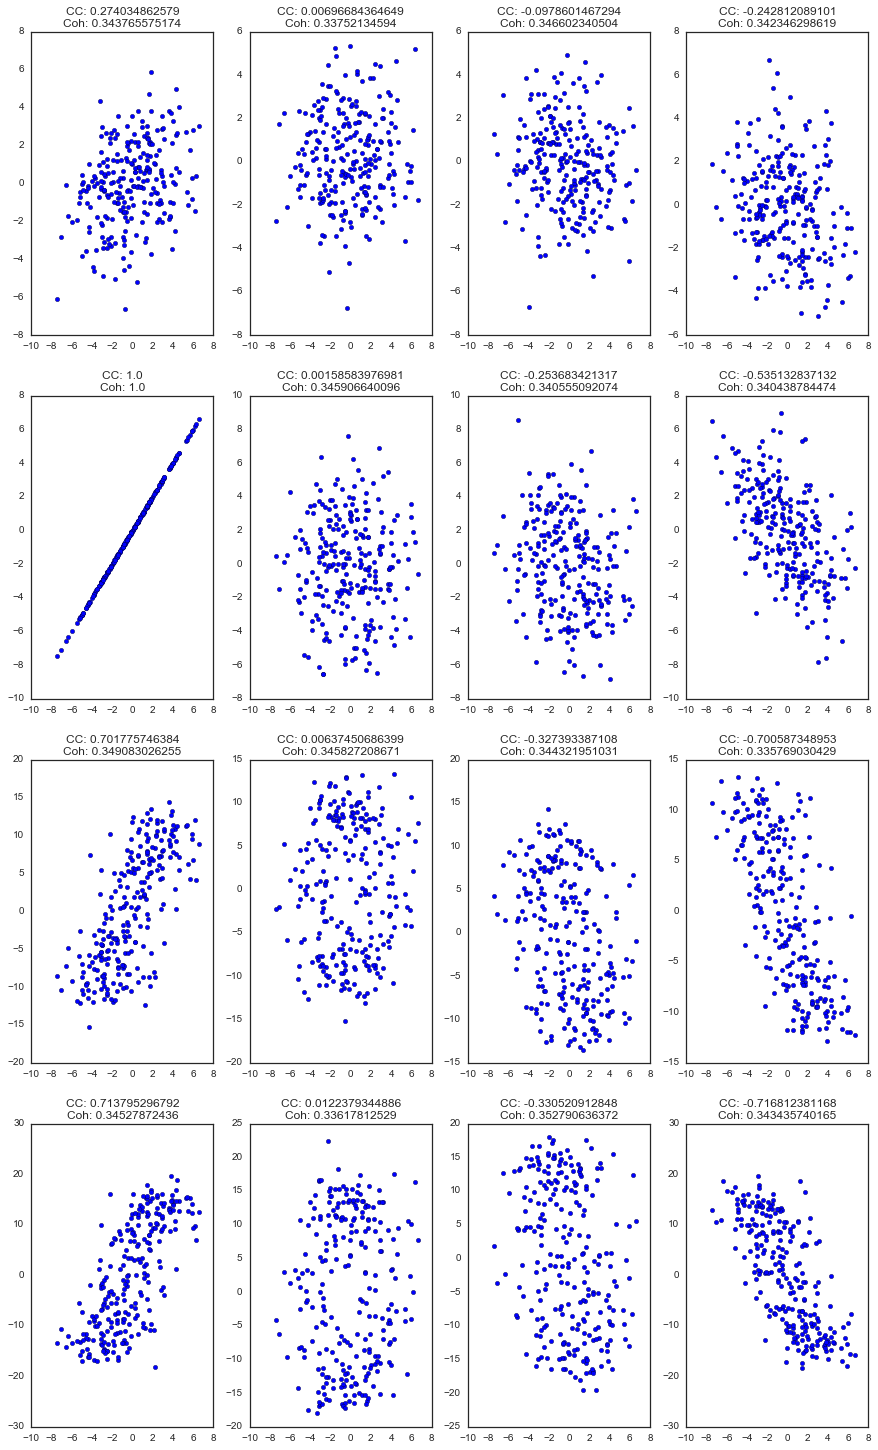

In [ ]:
# Set up a dataframe for plotting
noise_level = noise_levels[1]
plt_df = con_all.copy()
plt_df = con_all[noise_level].unstack('con')

# Define 16 signals to plot
sig_combinations = list(product([ix_ref], range(16)))

plt_sig = signals.xs(noise_level, level='noise_level')
n_combs = len(sig_combinations)
f, axs = plt.subplots(n_combs/4, 4, figsize=(15, n_combs/3*5))
for (comp_a, comp_b), ax in zip(sig_combinations, axs.ravel()):
    iia, iib = plt_sig.iloc[[comp_a, comp_b]].T.head(250).values.T
    ax.scatter(iia, iib)
    ax.set_title('CC: {0}\nCoh: {1}'.format(*plt_df.iloc[comp_b, :].values))

Finally, for a more direct comparison, we can look directly at the difference between the two as a function of both noise level and the sine wave parameters.

In [ ]:
diff_con = con_all.stack('noise_level').unstack('con')
diff = diff_con['cc'] - diff_con['coh']
diff = diff.unstack('noise_level')

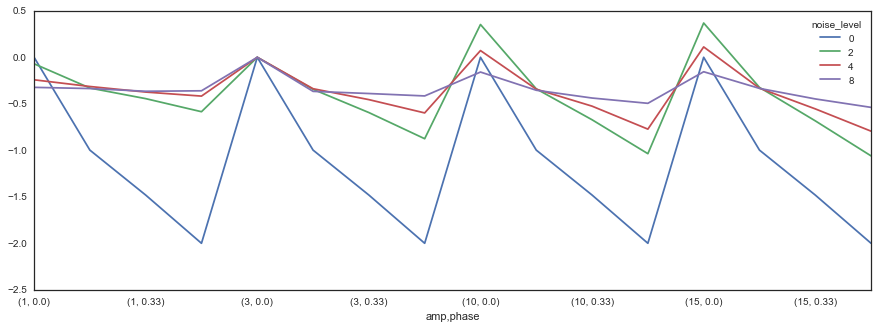

In [ ]:
diff.plot(figsize=(15, 5))

So what does this mean? Well, the relationship between coherence and correlation is too complicated to sum it up in a single line or two. However, it is clear that correlation is more sensitive to differences between signals in time. Coherence, on the other hand, is more reliable for these differences. Moreover, correlation degrades quickly with an increase in noise, while coherence remains the same.

As such, if you care about understanding the relationship between two signals as it pertains to time, then perhaps correlation is the way to go. On the other hand, if you want a robust estimate of the amount of overlap in the structure of two signals, then coherence may be the best bet.